In [2]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Conv2D
import matplotlib.image as img

In [9]:
# Define your directories and parameters
train_dir = "braintumor-dataset/Training"
test_dir = "braintumor-dataset/Testing"
img_size = (224, 224)
batch_size = 32

# Load and preprocess your data
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=img_size,
    label_mode="categorical",
    batch_size=batch_size,
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=img_size,
    label_mode="categorical",
    batch_size=batch_size,
)


#Define Classes Names
class_names= train_data.class_names
class_names

# Define callbacks
callback_list = [
    callbacks.EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.8, monitor="val_accuracy", patience=3),
]

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [6]:
# Define your model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="Input_layer")
x = base_model(inputs)
x = Conv2D(32, 3, padding='same', activation="relu", name="Top_Conv_Layer")(x)
x = tf.keras.layers.GlobalAveragePooling2D(name="Global_avg_Pooling_2D")(x)
outputs = tf.keras.layers.Dense(4, activation="softmax", name="Output_layer")(x)
Model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
Model_1.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

# Train the model
Model_1_History = Model_1.fit(
    train_data,
    validation_data=test_data,
    epochs=5,
    verbose=1,
    callbacks=callback_list,
)

# Define Grad-CAM functions
last_conv_layer_name = "Top_Conv_Layer"

def get_img_array(img_path, size=(224, 224)):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model=Model_1, last_conv_layer_name=last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap and handle NaN values
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap + 1e-8)
    heatmap = tf.where(tf.math.is_nan(heatmap), tf.zeros_like(heatmap), heatmap)

    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.5, view=False):
    """
    Saves and displays the Grad-CAM heatmap overlaid on the original image.
    Alpha value controls the transparency of the heatmap.
    """
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use the jet colormap to colorize the heatmap for better visibility
    jet = mpl.colormaps.get_cmap("jet")

    # Apply the colormap to the heatmap
    jet_colors = jet(np.arange(256))[:, :3]  # Extract RGB values
    jet_heatmap = jet_colors[heatmap]

    # Create an image from the heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))  # Resize to match the original image size
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display the Grad-CAM if required
    if view:
        display(Image(cam_path))

def decode_predictions(preds):
    classes = ['Glioma', 'meningioma', 'No Tumor', 'Pituitary']
    prediction = classes[np.argmax(preds)]
    return prediction

def make_prediction(img_path, model=Model_1, last_conv_layer_name=last_conv_layer_name, campath="cam.jpeg", view=False):
    img_array = get_img_array(img_path)
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    save_and_display_gradcam(img_path, heatmap, cam_path=campath, view=view)
    return [campath, decode_predictions(preds)]

Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 118s 600ms/step - accuracy: 0.7771 - loss: 0.5852 - val_accuracy: 0.8833 - val_loss: 0.3006 - learning_rate: 0.0010
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 102s 573ms/step - accuracy: 0.9165 - loss: 0.2164 - val_accuracy: 0.9260 - val_loss: 0.1967 - learning_rate: 0.0010
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 101s 567ms/step - accuracy: 0.9424 - loss: 0.1564 - val_accuracy: 0.9390 - val_loss: 0.1550 - learning_rate: 0.0010
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 103s 577ms/step - accuracy: 0.9545 - loss: 0.1223 - val_accuracy: 0.9405 - val_loss: 0.1544 - learning_rate: 0.0010
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 105s 588ms/step - accuracy: 0.9650 - loss: 0.0969 - val_accuracy: 0.9504 - val_loss: 0.1315 - learning_rate: 0.0010


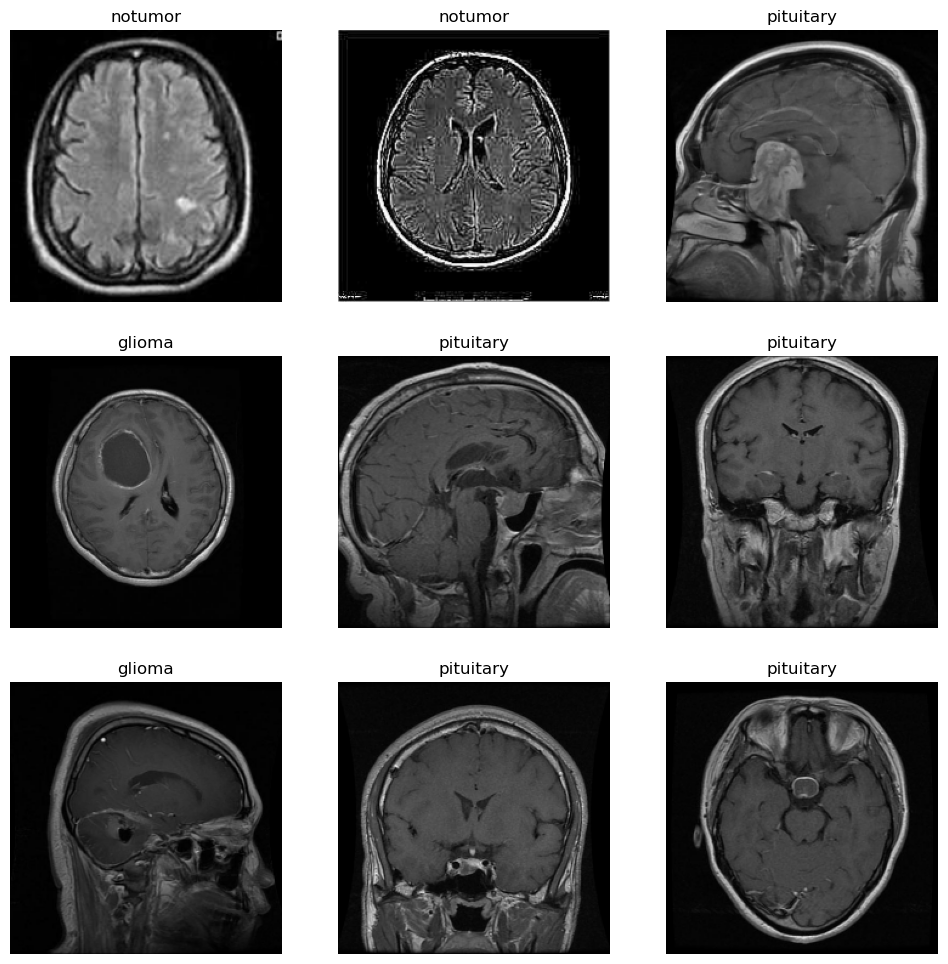

In [8]:
plt.figure(figsize=(12, 12))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.savefig("output_image.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
meningioma


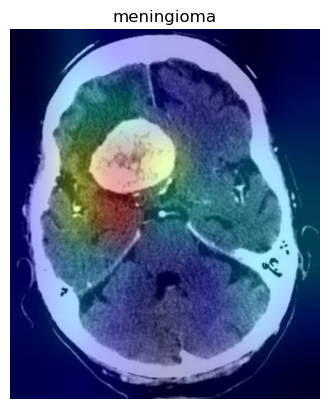

In [12]:
# Make a prediction and visualize the Grad-CAM
campath, prediction = make_prediction(
    "braintumor-dataset/Testing/meningioma/Te-me_0015.jpg",
    campath="123.jpeg",
    view=False,
)
print(prediction)

# Display the image with Grad-CAM overlay
test_img = img.imread(campath)
plt.imshow(test_img)
plt.title(prediction)
plt.axis("off")
plt.show()

plt.savefig("output_image1.png")
